# **Neural Bag of Words (NBoW) model for sentiment analysis**

## Import modules and packages
Import all the necessary modules and packages necessary to build, train, and evaluate the model. Also, set random seeds so that the program can be run for multiple seeds to check how variant the model's performance is.

In [70]:
!pip install -r requirements.txt

import collections,os,random,time
import matplotlib.pyplot as plt
import numpy as np
import datasets

import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset
import torchtext
import torchtext.data as ttd
import torchtext.vocab as ttv

#Set the environment time
os.environ["TZ"]="US/Eastern"
time.tzset()

#Set the seed
sd=random.randint(0,50)
np.random.seed(sd)
torch.manual_seed(sd)
torch.cuda.manual_seed(sd)
torch.backends.cudnn.deterministic=True

## IMDb dataset
The IMDb dataset from HuggingFace will be used for model development.

### Define the dataset
Download the 'train' and 'test' splits of the dataset, and inspect its characteristics.

In [55]:
#Download the 'train' and the 'test' splits of the IMDb dataset
trSet,tsSet=datasets.load_dataset('imdb',split=['train','test'])
print('The respective sizes of the training and the testing datasets are {} and {} respectively. \nThe sentiment class labels are {}.'.format(trSet.num_rows,tsSet.num_rows,trSet.features['label']))
print('A sample picked from any dataset would look as shown below:\n\n{}'.format(trSet[0]))

The respective sizes of the training and the testing datasets are 25000 and 25000 respectively. 
The sentiment class labels are ClassLabel(names=['neg', 'pos'], id=None).
A sample picked from any dataset would look as shown below:

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on po

### Tokenization
Convert the datasets from collections of strings to collections of numbers so that it is possible for any machine learning model to process them.

In [56]:
#The function that performs tokenization on a dataset
def tokenize(dataset,tokenizer,maxLength):
    tokens=tokenizer(dataset["text"])[:maxLength]
    return {'tokens':tokens}

#Define the tokenizer and carry out tokenization
maxLength=256       #maximum length of each token
tokenizer=ttd.utils.get_tokenizer('basic_english')
print('Tokenizing the training dataset...')
trSet=trSet.map(tokenize,fn_kwargs={'tokenizer':tokenizer,'maxLength':maxLength})
print('Tokenizing the testing dataset...')
tsSet=tsSet.map(tokenize,fn_kwargs={'tokenizer':tokenizer,'maxLength':maxLength})
print('\nThe contents of the tokenized datasets are as follows:\n{}.'.format(trSet))
print('\n\nA sample from the tokenized dataset would look as shown below:\n\n1. Text:\n{}'.format(trSet[0]['text']))
print('\n2. Label:\n{}'.format(trSet[0]['label']))
print('\n3. Tokens:\n{}'.format(trSet[0]['tokens']))

Tokenizing the training dataset...
Tokenizing the testing dataset...

The contents of the tokenized datasets are as follows:
Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
}).


A sample from the tokenized dataset would look as shown below:

1. Text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of S

### Validation dataset
Set aside a portion of the tokenized training dataset as the validation dataset.

In [57]:
valRatio=0.25
tempSet=trSet.train_test_split(test_size=valRatio)
trSet=tempSet['train']
valSet=tempSet['test']
print('The respective final sizes of the training, the validation, and the testing datasets are: {}, {}, and {} respectively.'.format(len(trSet),len(valSet),len(tsSet)))

The respective final sizes of the training, the validation, and the testing datasets are: 18750, 6250, and 25000 respectively.


### Vocabulary
Convert the tokens into one-hot representations by defining a minimum threshold frequency of occurence for each token and the unknown and the padding tokens.

In [58]:
#Define the vocabulary
threshold=5                 #minimum frequency of occurence for a token to be assigned a one-hot representation
spclTokens=['<unk>','<pad>']#to represent tokens with frequency<threshold and for padding to make all sentences have the same lengths
vocabulary=ttv.build_vocab_from_iterator(trSet['tokens'],min_freq=threshold,specials=spclTokens)
print('The number of tokens in the vocabulary is {}.'.format(len(vocabulary)))

#Indices of the special tokens in the vocabulary
idxUnk,idxPad=vocabulary['<unk>'],vocabulary['<pad>']
vocabulary.set_default_index(idxUnk)#set '<unk>' as the default token for any new words encounterd. Otherwise, new words will raise an error

The number of tokens in the vocabulary is 21547.


### Numerize the vocabulary
Convert the tokens into a numerical format so that they can be processed by neural networks.

In [59]:
#The function that numerizes the tokens in a dataset
def numerize(dataset,vocabulary):
  indices=vocabulary.lookup_indices(dataset['tokens'])
  return {'indices':indices}

#Numerize the datasets
print('Numerizing the training dataset...')
trSet=trSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('Numerizing the validation dataset...')
valSet=valSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('Numerizing the testing dataset...')
tsSet=tsSet.map(numerize,fn_kwargs={'vocabulary':vocabulary})
print('\nThe contents of the numerized datasets are as follows:\n{}.'.format(trSet))
print('\n\nA sample from the numerized dataset would look as shown below:\n\n1. Text:\n{}'.format(trSet[0]['text']))
print('\n2. Label:\n{}'.format(trSet[0]['label']))
print('\n3. Tokens:\n{}'.format(trSet[0]['tokens']))
print('\n4. Indices:\n{}'.format(trSet[0]['indices']))

#Convert the datasets to tensors after retaining only 'label' and 'indices'
trSet=trSet.with_format(type="torch",columns=['indices','label'])
valSet=valSet.with_format(type="torch",columns=['indices','label'])
tsSet=tsSet.with_format(type="torch",columns=['indices','label'])
print('\nThe numerized datasets\' contents after their conversion to tensors are as follows:\n{}.'.format(trSet))
print('\n\nA sample from a dataset tensor would look as shown below:\n\n1. Label:\n{}'.format(trSet[0]['label']))
print('\n2. Indices:\n{}'.format(trSet[0]['indices']))

Numerizing the training dataset...


Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Numerizing the validation dataset...


Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Numerizing the testing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


The contents of the numerized datasets are as follows:
Dataset({
    features: ['text', 'label', 'tokens', 'indices'],
    num_rows: 18750
}).


A sample from the numerized dataset would look as shown below:

1. Text:
Spend your time any other way, even housework is better than this movie. The jokes aren't funny, the fun rhymes that are Dr. Seus aren't there. A very lousy way to waste an evening. My kids 4-16 laughed a little at the beginning the younger ones got bored with it and left to play Barbies and the older ones left to play ps2 and surf the net. My wife left and did dishes. So I finished it alone. It was the worst "kids" movie I have seen. If you want to watch a fun kids movie watch Shrek 2, that movie is fun for kids and their parents. AVOID THIS MOVIE. It isn't funny, isn't cute, the cat's makeup is about the only good thing in it and you can see that on the disc label.

2. Label:
0

3. Tokens:
['spend', 'your', 'time', 'any', 'other', 'way', ',', 'even', 'housework', 'is',

### Data loader

In [80]:
#The class prepares batches of data that can be iterated over by the data loader.
#The batch is prepared by collating a group of data samples in the function
#'collate'. The function also pads the shorter sequences in the batch with '<pad>'
#to make their lengths equal to that of the bacth's longest sequence. This
#ensures that the neural network model's I/P dimension remains fixed.
class sentimentDataset(Dataset):
  def __init__(self,dataset,batchSize,idxPad,shuffle=False):
    self.dataset,self.batchSize=dataset,batchSize
    self.idxPad=idxPad
    self.shuffle=False

  def collate(self,batch):
    batchLabels=[sample['label'] for sample in batch]
    batchIndices=[sample['indices'] for sample in batch]
    batchLabels=torch.stack(batchLabels)
    batchIndices=nn.utils.rnn.pad_sequence(batchIndices,padding_value=self.idxPad,batch_first=True)
    print('Batch size is {} and {}.'.format(batchIndices.shape,batchLabels.shape))
    return {'indices':batchIndices,'label':batchLabels}

  def loadData(self):
    dataLoader=torch.utils.data.DataLoader(dataset=self.dataset,batch_size=self.batchSize,collate_fn=self.collate,shuffle=self.shuffle)
    return dataLoader

def dataIterators(set,dataset,params):
    if set=='train':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=False)
    elif set=='validate':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=False)
    elif set=='test':obj=sentimentDataset(dataset,params['batchSize'],params['padIndex'],shuffle=False)
    return obj.loadData()

## NBoW model for sentiment classification
The sentiment classification model will be an NBoW with an architecture as defined below:

In [81]:
class nbow(nn.Module):
  #Initializes the neural bag of words class
  def __init__(self,vocabularySize,embDim,opDim,idxPad):
    super(nbow,self).__init__()
    self.embed=nn.Embedding(vocabularySize,embDim,padding_idx=idxPad)
    self.linear=nn.Linear(embDim,opDim)

  #Forward propagates a batch of size [batchSize,sequenceLength] through the network
  def forward(self,x):
    x1=self.embed(x)              #size is [batchSize,sequenceLength,embDim]
    x1Pooled=x1.mean(dim=1)       #size is [batchSize,embDim]
    labelHat=self.linear(x1Pooled)#prediction's size is [batchSize,opDim]
    return labelHat

## Model training and evaluation
The functions that train, validate, and evaluate the NBoW model are defined below.

In [82]:
#This function trains and validates the model
def train(vocabulary,trDataLoader,valDataLoader,params):
  #Define the model and initialize its embedding layer's weights with pretrained
  #weights from Glove
  model=nbow(params['vocabSize'],params['embDim'],params['opDim'],params['padIndex']).to(params['device'])
  vectors=torchtext.vocab.GloVe()      #initializing embedded layer with pretrained weights from Glove
  temp=vocabulary.get_itos()           #vocabulary tokens represented as a list
  pretrainEmb=vectors.get_vecs_by_tokens(temp)
  model.embed.weight.data=pretrainEmb#replace embedding layer's initial random weights with pretrained weights
  #Define the cost-function and the optimizer
  optimizer=optim.Adam(model.parameters(),lr=params['alpha'])
  costFun=nn.CrossEntropyLoss().to(params['device'])
  #Start training the model
  metrics=collections.defaultdict(list)
  model.train()                        #configure the model for training
  for epoch in range(params['epochs']):#loop for epochs
    trLosses,trAccuracies=[],[]
    #Loop over each training batch
    for dataBatch in tqdm.tqdm(trDataLoader,desc='Model training in progress...'):
      ids=dataBatch['indices'].to(params['device'])
      labels=dataBatch['label'].to(params['device'])
      #Forward propagation
      labelsHat=model(ids)
      loss=costFun(labelsHat,labels)
      accuracy=getAccuracy(labelsHat,labels)
      #Backpropagation
      optimizer.zero_grad()            #initialize all gradients to zero
      loss.backward()
      optimizer.step()
      #Update the losses
      trLosses.append(loss.item())
      trAccuracies.append(accuracy.item())
    metrics['train_accs'].append(np.mean(trAccuracies))
    metrics['train_losses'].append(np.mean(trLosses))
    #Validate the model after each epoch
    bestValLoss=float('inf')
    model.eval()                       #configure the model for evaluation
    valLosses,valAccuracies=[],[]
    with torch.no_grad():              #backpropagation not required
      for dataBatch in tqdm.tqdm(valDataLoader,desc='Model validation in progress...'):
        ids=dataBatch['indices'].to(params['device'])
        labels=dataBatch['label'].to(params['device'])
        #Forward propagation
        labelsHat=model(ids)
        loss=costFun(labelsHat,labels)
        accuracy=getAccuracy(labelsHat,labels)
        #Update the losses
        valLosses.append(loss.item())
        valAccuracies.append(accuracy.item())
    metrics['valid_accs'].append(np.mean(valAccuracies))
    metrics['valid_losses'].append(np.mean(valLosses))
    if np.mean(valLosses)<bestValLoss:
      bestValLoss=np.mean(valLosses)
      torch.save(model.state_dict(),'nbow.pt')
    print(f'Epoch: {epoch}')
    print(f'Training loss: {np.mean(trLosses):.3f}, Training accuracy: {np.mean(trAccuracies):.3f}')
    print(f'Validation loss: {np.mean(valLosses):.3f}, Validation accuracy: {np.mean(valAccuracies):.3f}\n\n')
  return model,costFun,metrics

#This function evaluates the model
def evaluate(model,tsDataLoader,costFun,params):
  model.eval()                         #configure the model for evaluation
  tsLosses,tsAccuracies=[],[]
  with torch.no_grad():                #backpropagation not required
    for dataBatch in tqdm.tqdm(tsDataLoader,desc='Model evaluation in progress...'):
      ids=dataBatch['indices'].to(params['device'])
      labels=dataBatch['label'].to(params['device'])
      #Forward propagation
      labelsHat=model(ids)
      loss=costFun(labelsHat,labels)
      accuracy=getAccuracy(labelsHat,labels)
      #Update the losses
      tsLosses.append(loss.item())
      tsAccuracies.append(accuracy.item())
  return np.mean(tsLosses),np.mean(tsAccuracies)

#This function computes the accuracies of prediction for a given batch of data
def getAccuracy(yHat,y):
  batchSize,_=yHat.shape
  labelsHat=yHat.argmax(dim=-1)        #predicted class labels
  TP=labelsHat.eq(y).sum()             #true positives
  return (TP/batchSize)

## Main function

Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  7.50it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  7.93it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.09it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.16it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.09it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  7.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  6.88it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:02,  6.67it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:03<00:02,  6.57it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  6.86it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  7.58it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.07it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:04<00:00,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.41it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  7.83it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 14.94it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.45it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.84it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 16.96it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 16.98it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 17.89it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 0
Training loss: 0.677, Training accuracy: 0.641
Validation loss: 0.659, Validation accuracy: 0.711




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  8.47it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.38it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:03,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.18it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.11it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.39it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  8.38it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:03<00:00,  8.40it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  8.33it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 15.05it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.68it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 16.86it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 17.00it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 17.80it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 1
Training loss: 0.636, Training accuracy: 0.728
Validation loss: 0.610, Validation accuracy: 0.747




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  7.90it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:03,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.42it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.45it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.48it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.42it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:02,  8.42it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.43it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.04it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  7.47it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  7.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  6.93it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  6.81it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  6.83it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  6.83it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:01,  6.87it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:01,  6.72it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:04<00:00,  6.74it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:04<00:00,  7.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  7.48it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  7.52it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  7.57it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  7.86it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 16.57it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.87it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 17.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 17.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 17.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 18.16it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 2
Training loss: 0.575, Training accuracy: 0.772
Validation loss: 0.547, Validation accuracy: 0.783




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  8.43it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:03,  8.38it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.38it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.38it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:03<00:00,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  8.39it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 15.60it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.60it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.84it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 17.02it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 16.94it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 17.84it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 3
Training loss: 0.503, Training accuracy: 0.815
Validation loss: 0.484, Validation accuracy: 0.817




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  7.79it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.16it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:03,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.12it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.10it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.39it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.40it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.01it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:01,  7.93it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  7.41it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  7.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  7.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  7.43it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  7.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  7.11it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  97%|█████████▋| 36/37 [00:04<00:00,  7.04it/s]

Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 13.77it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 13.73it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 15.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 16.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 16.62it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 16.76it/s]


Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 4
Training loss: 0.437, Training accuracy: 0.850
Validation loss: 0.432, Validation accuracy: 0.841




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  8.59it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:03,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.39it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.41it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.45it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.43it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:03,  7.97it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.08it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.20it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.12it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:03<00:00,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  8.34it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 14.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.74it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 17.01it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 17.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 18.11it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 5
Training loss: 0.382, Training accuracy: 0.871
Validation loss: 0.394, Validation accuracy: 0.854




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  7.63it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.04it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:04,  8.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.12it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.04it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.16it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.13it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.00it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.16it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.36it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:04<00:00,  5.61it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  6.45it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  97%|█████████▋| 36/37 [00:04<00:00,  6.51it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 14.34it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 13.92it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 13.73it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 13.00it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 14.26it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 6
Training loss: 0.340, Training accuracy: 0.885
Validation loss: 0.366, Validation accuracy: 0.863




Model training in progress...:   3%|▎         | 1/37 [00:00<00:05,  7.11it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  7.69it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  7.96it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:04,  7.83it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:04,  7.99it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.08it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.08it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:01<00:03,  8.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.10it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.09it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  7.97it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.01it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.08it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.14it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  8.23it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 17.27it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 16.00it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 16.66it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 16.92it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 17.92it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 7
Training loss: 0.307, Training accuracy: 0.896
Validation loss: 0.345, Validation accuracy: 0.867




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:04,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:04,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:04,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:04,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:03,  8.17it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:03,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:00<00:03,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:00<00:03,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  8.32it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  8.31it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:02,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  8.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:01<00:02,  8.20it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:01<00:02,  8.20it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.22it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:02<00:01,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:02<00:01,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.28it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.37it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.35it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.10it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:03<00:00,  8.06it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  8.12it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.16it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  8.30it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:   0%|          | 0/13 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 15.33it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 15.49it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 15.43it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 14.56it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 14.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 15.23it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 8
Training loss: 0.280, Training accuracy: 0.907
Validation loss: 0.330, Validation accuracy: 0.871




Model training in progress...:   0%|          | 0/37 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   3%|▎         | 1/37 [00:00<00:05,  6.74it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   5%|▌         | 2/37 [00:00<00:05,  6.61it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:   8%|▊         | 3/37 [00:00<00:05,  6.78it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  11%|█         | 4/37 [00:00<00:04,  6.76it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  14%|█▎        | 5/37 [00:00<00:04,  6.63it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  16%|█▌        | 6/37 [00:00<00:04,  6.58it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  19%|█▉        | 7/37 [00:01<00:04,  6.74it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  22%|██▏       | 8/37 [00:01<00:04,  7.17it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  24%|██▍       | 9/37 [00:01<00:03,  7.46it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  27%|██▋       | 10/37 [00:01<00:03,  7.60it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  30%|██▉       | 11/37 [00:01<00:03,  7.76it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  32%|███▏      | 12/37 [00:01<00:03,  7.68it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  35%|███▌      | 13/37 [00:01<00:03,  7.85it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  38%|███▊      | 14/37 [00:01<00:02,  7.89it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  41%|████      | 15/37 [00:02<00:02,  7.85it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  43%|████▎     | 16/37 [00:02<00:02,  7.87it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  46%|████▌     | 17/37 [00:02<00:02,  8.00it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  49%|████▊     | 18/37 [00:02<00:02,  7.93it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  51%|█████▏    | 19/37 [00:02<00:02,  8.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  54%|█████▍    | 20/37 [00:02<00:02,  8.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  57%|█████▋    | 21/37 [00:02<00:01,  8.15it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  59%|█████▉    | 22/37 [00:02<00:01,  8.19it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  62%|██████▏   | 23/37 [00:03<00:01,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  65%|██████▍   | 24/37 [00:03<00:01,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  68%|██████▊   | 25/37 [00:03<00:01,  8.24it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  70%|███████   | 26/37 [00:03<00:01,  8.25it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  73%|███████▎  | 27/37 [00:03<00:01,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  76%|███████▌  | 28/37 [00:03<00:01,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  78%|███████▊  | 29/37 [00:03<00:00,  8.30it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  81%|████████  | 30/37 [00:03<00:00,  8.29it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  84%|████████▍ | 31/37 [00:03<00:00,  8.26it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  86%|████████▋ | 32/37 [00:04<00:00,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  89%|████████▉ | 33/37 [00:04<00:00,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  92%|█████████▏| 34/37 [00:04<00:00,  8.23it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...:  95%|█████████▍| 35/37 [00:04<00:00,  8.12it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model training in progress...: 100%|██████████| 37/37 [00:04<00:00,  7.90it/s]


Batch size is torch.Size([318, 256]) and torch.Size([318]).


Model validation in progress...:  15%|█▌        | 2/13 [00:00<00:00, 17.01it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  31%|███       | 4/13 [00:00<00:00, 17.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  46%|████▌     | 6/13 [00:00<00:00, 16.51it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  62%|██████▏   | 8/13 [00:00<00:00, 16.74it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...:  77%|███████▋  | 10/13 [00:00<00:00, 16.79it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model validation in progress...: 100%|██████████| 13/13 [00:00<00:00, 17.93it/s]


Batch size is torch.Size([106, 256]) and torch.Size([106]).
Epoch: 9
Training loss: 0.257, Training accuracy: 0.916
Validation loss: 0.318, Validation accuracy: 0.877


Model training complete, and the model has 6464702 learnable parameters.




Model evaluation in progress...:   0%|          | 0/49 [00:00<?, ?it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:   4%|▍         | 2/49 [00:00<00:03, 14.70it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:   8%|▊         | 4/49 [00:00<00:03, 14.81it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  12%|█▏        | 6/49 [00:00<00:02, 15.42it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  16%|█▋        | 8/49 [00:00<00:02, 15.69it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  20%|██        | 10/49 [00:00<00:02, 15.93it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  24%|██▍       | 12/49 [00:00<00:02, 15.96it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  29%|██▊       | 14/49 [00:00<00:02, 15.98it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  33%|███▎      | 16/49 [00:01<00:02, 15.92it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  37%|███▋      | 18/49 [00:01<00:01, 16.02it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  41%|████      | 20/49 [00:01<00:01, 16.03it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  45%|████▍     | 22/49 [00:01<00:01, 16.10it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  49%|████▉     | 24/49 [00:01<00:01, 16.13it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  53%|█████▎    | 26/49 [00:01<00:01, 15.80it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  57%|█████▋    | 28/49 [00:01<00:01, 15.86it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  61%|██████    | 30/49 [00:01<00:01, 15.97it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  65%|██████▌   | 32/49 [00:02<00:01, 16.04it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  69%|██████▉   | 34/49 [00:02<00:00, 15.63it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  73%|███████▎  | 36/49 [00:02<00:00, 15.85it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  78%|███████▊  | 38/49 [00:02<00:00, 15.96it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  82%|████████▏ | 40/49 [00:02<00:00, 16.07it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  86%|████████▌ | 42/49 [00:02<00:00, 16.21it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  90%|████████▉ | 44/49 [00:02<00:00, 16.13it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...:  94%|█████████▍| 46/49 [00:02<00:00, 16.20it/s]

Batch size is torch.Size([512, 256]) and torch.Size([512]).


Model evaluation in progress...: 100%|██████████| 49/49 [00:03<00:00, 15.99it/s]


Batch size is torch.Size([512, 256]) and torch.Size([512]).
Batch size is torch.Size([424, 256]) and torch.Size([424]).
Testing loss: 0.351, Testing accuracy: 0.858


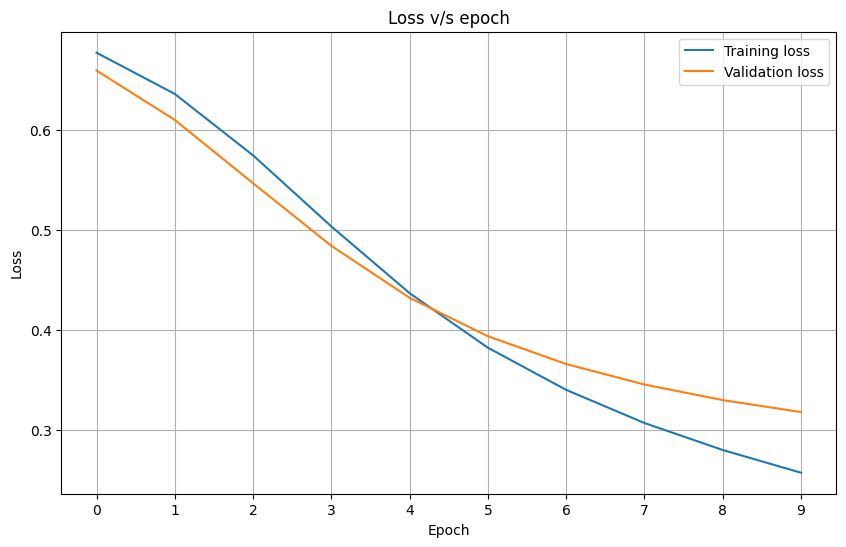

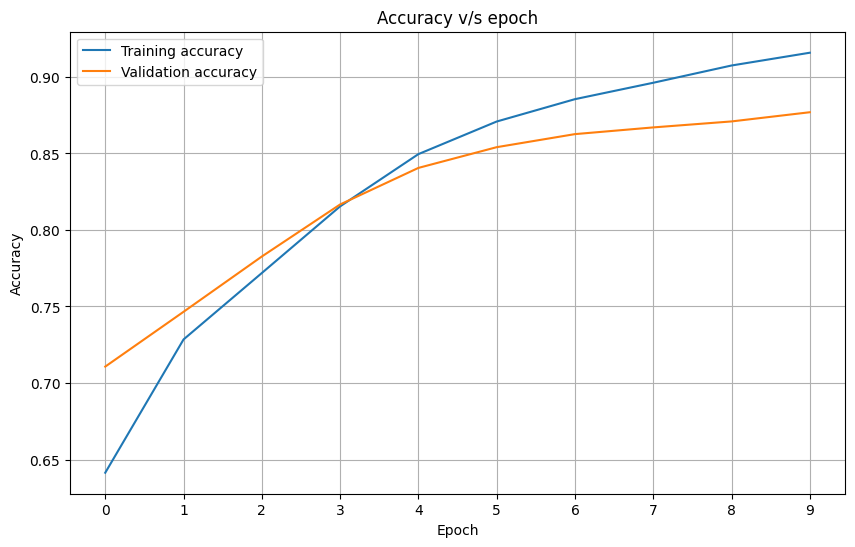

In [83]:
if __name__=='__main__':
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device=torch.device('cpu')
    params={'device':device,
            'epochs':10,
            'batchSize':512,
            'alpha':1e-3,
            'vocabSize':len(vocabulary),
            'embDim':300, #pretraining embedded layer with Glove that has a default dimension of 300
            'opDim':len(trSet.unique('label')),
            'padIndex':idxPad,
            'unknownIndex':idxUnk}
    trIterator=dataIterators('train',trSet,params)
    valIterator=dataIterators('validate',valSet,params)
    tsIterator=dataIterators('test',tsSet,params)
    #Train the NBoW model
    model,costFun,metrics=train(vocabulary,trIterator,valIterator,params)
    print('Model training complete, and the model has {} learnable parameters.\n\n'.format(sum(weight.numel() for weight in model.parameters() if weight.requires_grad==True)))
    #Plot the learning curves
    figure1=plt.figure(figsize=(10,6))
    axis=figure1.add_subplot(1,1,1)
    axis.plot(metrics['train_losses'],label='Training loss')
    axis.plot(metrics['valid_losses'], label='Validation loss')
    axis.set_xticks(range(params['epochs']))
    axis.set_title('Loss v/s epoch')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Loss')
    axis.legend()
    axis.grid()
    figure2=plt.figure(figsize=(10,6))
    axis=figure2.add_subplot(1,1,1)
    axis.plot(metrics['train_accs'], label='Training accuracy')
    axis.plot(metrics['valid_accs'], label='Validation accuracy')
    axis.set_xticks(range(params['epochs']))
    axis.set_title('Accuracy v/s epoch')
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epoch')
    axis.legend()
    axis.grid()
    #Evaluate the NBoW model
    model.load_state_dict(torch.load('nbow.pt'))#equate model weights to that of the one with the best validation results
    loss,accuracy=evaluate(model,tsIterator,costFun,params)
    print(f'Testing loss: {loss:.3f}, Testing accuracy: {accuracy:.3f}')